In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import importlib
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
from utils import collect, dataset, callbacks
from models import lstm, seq2seq

In [28]:
importlib.reload(collect)
importlib.reload(dataset)
importlib.reload(lstm)
importlib.reload(seq2seq)

<module 'models.seq2seq' from '/app/models/seq2seq.py'>

In [3]:
INPUT_WIDTH = 14
LABEL_WIDTH = 15
LAYER_SIZE = 512
DROPOUT = 0.2
EPOCHS = 300
BATCH_SIZE = 256
ATTENTION = True

In [4]:
RMSE = lambda x, y: mean_squared_error(x, y, squared=False)
MAE = mean_absolute_error
MAPE = mean_absolute_percentage_error

In [291]:
def evaluation(y_true, y_pred):
    result = []
    for x, y in zip(y_true, y_pred):
        result.append([
            RMSE(x, y),
            MAE(x, y),
            MAPE(x, y)
        ])
    result = np.array(result)
    result = np.mean(result, axis=0)
    result = np.around(result, 2)
    return result

In [211]:
import pickle

start_date = "20200303"
end_date = "20210806"

covid_fname = f"covid_{start_date}_{end_date}.csv"
scaler_fname = f"covid_{start_date}_{end_date}_scaler.pkl"

covid_data = collect.get_nation_covid_data(start_date, end_date)
covid_data = pd.read_csv(f"./data/{covid_fname}")

with open(f"./data/{scaler_fname}", "rb") as f:
    scaler = pickle.load(f)

In [7]:
covid_data

,accDefRate,accExamCnt,accExamCompCnt,careCnt,clearCnt,createDt,deathCnt,decideCnt,examCnt,resutlNegCnt,seq,stateDt,stateTime,updateDt
0,5.329140,125851,90296,4159,34,2020-03-03 10:46:53.53,28,4812,35555,85484,62,20200303,00:00,2020-03-03 10:46:53.53
1,4.919986,136707,108293,4750,41,2020-03-04 10:21:44.44,32,5328,28414,102965,63,20200304,00:00,2020-03-04 10:21:44.44
2,4.622748,146541,124731,5255,88,2020-03-05 10:15:12.12,35,5766,21810,118965,64,20200305,00:00,2020-03-05 10:15:12.12
3,4.397235,164740,142908,5643,108,2020-03-06 12:55:44.44,42,6284,21832,136624,65,20200306,00:00,2020-03-06 12:55:44.44
4,4.267543,178189,158569,6134,118,2020-03-07 11:00:45.45,44,6767,19620,151802,66,20200307,00:00,2020-03-07 11:00:45.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,1.756615,11751782,11373182,22011,175674,2021-08-01 09:38:06.089,2098,199783,378600,11173399,590,20210801,00:00,2021-08-02 14:36:31.883
517,1.765422,11772604,11385434,22297,176605,2021-08-02 09:37:51.966,2099,201001,387170,11184433,591,20210802,00:00,2021-08-03 11:08:09.679
518,1.770321,11820016,11421716,22188,177909,2021-08-03 09:38:51.531,2104,202201,398300,11219515,592,20210803,00:00,2021-08-04 09:58:25.377
519,1.778473,11864245,11466356,22697,179123,2021-08-04 09:49:14.864,2106,203926,397889,11262430,593,20210804,00:00,NaN


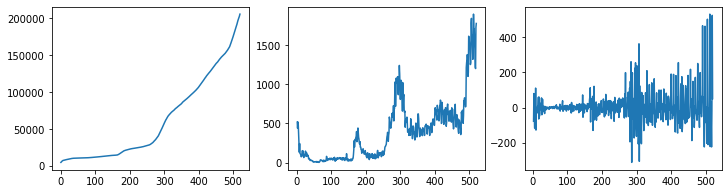

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].plot(covid_data["decideCnt"])
axes[1].plot(covid_data["decideCnt"].diff().dropna())
axes[2].plot(covid_data["decideCnt"].diff().diff().dropna())
plt.show()
plt.close()

In [19]:
from pmdarima.arima import auto_arima

In [33]:
target_data = covid_data[["decideCnt"]].values
target_data = np.diff(target_data, n=2, axis=0)
scaler = StandardScaler()
scaler.fit(target_data)
scaled_data = scaler.transform(target_data)

sarimax = SARIMAX(scaled_data[:-INPUT_WIDTH-LABEL_WIDTH-1],
                  order=(2, 0, 2), seasonal_order=(1, 0, 2, 52))
sarimax_fit = sarimax.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [34]:
sarimax_fit.aic

1078.2351478094415

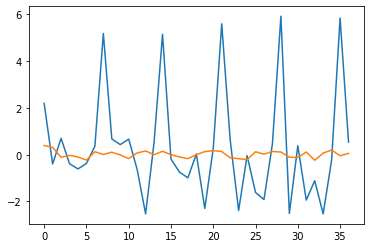

In [35]:
plt.plot(scaled_data[-INPUT_WIDTH-LABEL_WIDTH-1:])
plt.plot(sarimax_fit.get_forecast(INPUT_WIDTH+LABEL_WIDTH+1).predicted_mean)
plt.show()

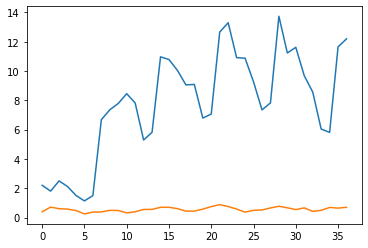

In [22]:
plt.plot(np.cumsum(scaled_data[-INPUT_WIDTH-LABEL_WIDTH-1:]))
plt.plot(np.cumsum(sarimax_fit.get_forecast(INPUT_WIDTH+LABEL_WIDTH+1).predicted_mean))
plt.show()

In [36]:
test_targ = scaled_data[-INPUT_WIDTH-LABEL_WIDTH-1:]
test_prds = sarimax_fit.get_forecast(INPUT_WIDTH+LABEL_WIDTH+1).predicted_mean

RMSE(test_targ, test_prds), MAE(test_targ, test_prds), MAPE(test_targ, test_prds)

(2.33465661259028, 1.5783360076368844, 1.0870893268564135)

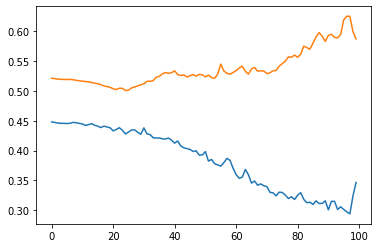

In [90]:
target_data = covid_data[["decideCnt"]].values
target_data = np.diff(target_data, n=2, axis=0)
scaler = StandardScaler()
scaler.fit(target_data)
scaled_data = scaler.transform(target_data)
ds = dataset.DataSlicer(scaled_data, scaled_data, INPUT_WIDTH, LABEL_WIDTH)
lstm_model = lstm.get_model(LAYER_SIZE, LABEL_WIDTH, DROPOUT)
history = lstm_model.fit(ds.train.batch(BATCH_SIZE), validation_data=ds.val.batch(BATCH_SIZE),
                         epochs=100, verbose=0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.close()

In [91]:
test_inp, test_targ = list(ds.test.batch(ds.test_size))[0]
test_prds = lstm_model(test_inp)
test_targ.shape, test_prds.shape

(TensorShape([70, 15, 1]), TensorShape([70, 15]))

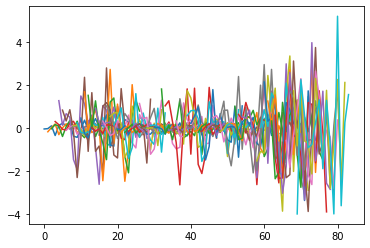

In [62]:
for i, prd in enumerate(test_prds):
    plt.plot(range(i, i+LABEL_WIDTH), prd)
plt.show()
plt.close()

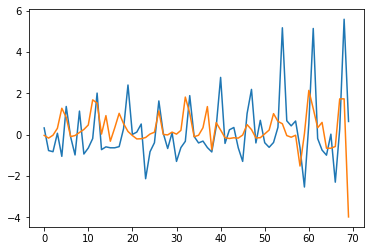

In [69]:
plt.plot(np.diff(test_targ[:, 0], n=0, axis=0))
plt.plot(np.diff(test_prds[:, 0], n=0, axis=0))
plt.show()
plt.close()

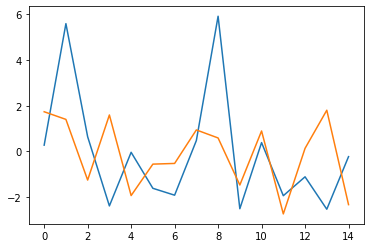

In [64]:
plt.plot(np.diff(test_targ[-3, :], n=0, axis=0))
plt.plot(np.diff(test_prds[-3, :], n=0, axis=0))
plt.show()
plt.close()

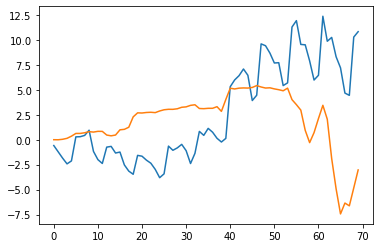

In [92]:
plt.plot(np.cumsum(test_targ[:, 14]))
plt.plot(np.cumsum(test_prds[:, 14]))
plt.show()
plt.close()

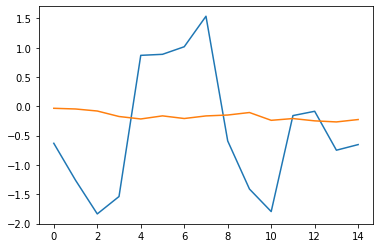

In [102]:
plt.plot(np.cumsum(test_targ[-55, :]))
plt.plot(np.cumsum(test_prds[-40, :]))
plt.show()
plt.close()

In [72]:
evaluation(test_targ, test_prds)

array([1.69, 1.28, 3.21])

In [170]:
covid_data

,accDefRate,accExamCnt,accExamCompCnt,careCnt,clearCnt,createDt,deathCnt,decideCnt,examCnt,resutlNegCnt,seq,stateDt,stateTime,updateDt
0,5.329140,125851,90296,4159,34,2020-03-03 10:46:53.53,28,4812,35555,85484,62,20200303,00:00,2020-03-03 10:46:53.53
1,4.919986,136707,108293,4750,41,2020-03-04 10:21:44.44,32,5328,28414,102965,63,20200304,00:00,2020-03-04 10:21:44.44
2,4.622748,146541,124731,5255,88,2020-03-05 10:15:12.12,35,5766,21810,118965,64,20200305,00:00,2020-03-05 10:15:12.12
3,4.397235,164740,142908,5643,108,2020-03-06 12:55:44.44,42,6284,21832,136624,65,20200306,00:00,2020-03-06 12:55:44.44
4,4.267543,178189,158569,6134,118,2020-03-07 11:00:45.45,44,6767,19620,151802,66,20200307,00:00,2020-03-07 11:00:45.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,1.756615,11751782,11373182,22011,175674,2021-08-01 09:38:06.089,2098,199783,378600,11173399,590,20210801,00:00,2021-08-02 14:36:31.883
517,1.765422,11772604,11385434,22297,176605,2021-08-02 09:37:51.966,2099,201001,387170,11184433,591,20210802,00:00,2021-08-03 11:08:09.679
518,1.770321,11820016,11421716,22188,177909,2021-08-03 09:38:51.531,2104,202201,398300,11219515,592,20210803,00:00,2021-08-04 09:58:25.377
519,1.778473,11864245,11466356,22697,179123,2021-08-04 09:49:14.864,2106,203926,397889,11262430,593,20210804,00:00,NaN


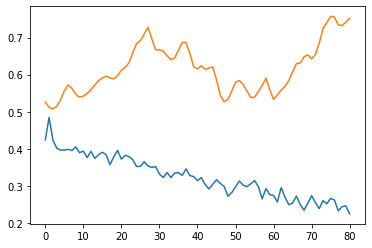

In [194]:
first_diff = np.diff(covid_data[["decideCnt"]], n=1, axis=0)
second_diff = np.diff(covid_data[["decideCnt"]], n=2, axis=0)

input_data = tf.concat([
    StandardScaler().fit_transform(first_diff)[1:], scaler.transform(second_diff)
], axis=-1)
label_data = scaler.transform(second_diff)

ds = dataset.DataSlicer(input_data, label_data, INPUT_WIDTH, LABEL_WIDTH, teacher_force=True)
seq2seq_model = seq2seq.get_model(LAYER_SIZE, INPUT_WIDTH, 2, LABEL_WIDTH, 1, DROPOUT, ATTENTION)
history = seq2seq_model.fit(ds.train.batch(BATCH_SIZE), validation_data=ds.val.batch(BATCH_SIZE),
                            epochs=200, verbose=0, callbacks=[
                                callbacks.EarlyStopping(min_epoch=50, patience=20)
                            ])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.close()

In [207]:
ds.val_size, test_inp[0].shape

(103, TensorShape([77, 14, 2]))

In [208]:
test_inp, test_targ = list(ds.test.batch(ds.test_size))[0]

test_enc_out, test_enc_state = seq2seq_model.layers[2](test_inp[0])
test_prds = tf.cast(test_inp[1][:, :1], dtype=tf.float32)
for step in range(LABEL_WIDTH):
    prd = seq2seq_model.layers[3](test_prds, test_enc_state, test_enc_out)
    test_prds = tf.concat([test_prds, prd[:, -1:, tf.newaxis]], axis=1)
test_prds = tf.squeeze(test_prds[:, 1:], axis=-1)
test_inverse_prds = scaler.inverse_transform(test_prds) + first_diff[-len(test_prds):]
test_prds.shape

TensorShape([77, 15])

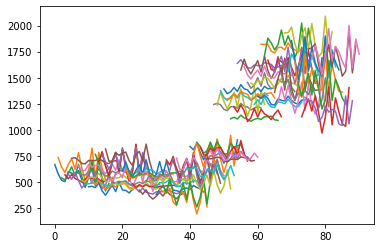

In [209]:
for i, prd in enumerate(test_inverse_prds):
    plt.plot(range(i, i+LABEL_WIDTH), prd)
plt.show()

In [210]:
evaluation(test_targ, test_prds)

array([1.61, 1.19, 2.7 ])

In [ ]:
target_data = covid_data[["decideCnt"]].values
daily_data = np.diff(target_data, n=1, axis=0)[INPUT_WIDTH:]
target_data = np.diff(target_data, n=2, axis=0)
# scaler = StandardScaler()
# scaler.fit(target_data)
scaled_data = scaler.transform(target_data)
ds = dataset.DataSlicer(scaled_data, None, INPUT_WIDTH, 0, teacher_force=True)

seq2seq_model = seq2seq.get_model(LAYER_SIZE, INPUT_WIDTH, 1, LABEL_WIDTH, 1, DROPOUT, ATTENTION)
# history = seq2seq_model.fit(ds.train.batch(BATCH_SIZE), validation_data=ds.val.batch(BATCH_SIZE),
#                             epochs=200, verbose=0, callbacks=[
#                                 callbacks.EarlyStopping(min_epoch=50, patience=20)
#                             ])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.show()
# plt.close()

In [244]:
target_data = covid_data[["decideCnt"]].values
daily_data = np.diff(target_data, n=1, axis=0)[INPUT_WIDTH:-LABEL_WIDTH]
target_data = np.diff(target_data, n=2, axis=0)
# scaler = StandardScaler()
# scaler.fit(target_data)
scaled_data = scaler.transform(target_data)
ds = dataset.DataSlicer(scaled_data, scaled_data, INPUT_WIDTH, LABEL_WIDTH, teacher_force=True)

seq2seq_model = seq2seq.get_model(LAYER_SIZE, INPUT_WIDTH, 1, LABEL_WIDTH, 1, DROPOUT, ATTENTION)
# history = seq2seq_model.fit(ds.train.batch(BATCH_SIZE), validation_data=ds.val.batch(BATCH_SIZE),
#                             epochs=200, verbose=0, callbacks=[
#                                 callbacks.EarlyStopping(min_epoch=50, patience=20)
#                             ])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.show()
# plt.close()

seq2seq_model.load_weights(f"./saved/seq2seq_iw{INPUT_WIDTH}_lw{LABEL_WIDTH}_ls{LAYER_SIZE}_do{DROPOUT}_diff{2}_bck.h5")

In [245]:
total_inp, total_targ = list(ds.total.batch(ds.data_size))[0]

total_enc_out, total_enc_state = seq2seq_model.layers[2](total_inp[0])
total_prds = tf.cast(total_inp[0][:, -1:], dtype=tf.float32)
for step in range(LABEL_WIDTH):
    prd = seq2seq_model.layers[3](total_prds, total_enc_state, total_enc_out)
    total_prds = tf.concat([total_prds, prd[:, -1:, tf.newaxis]], axis=1)
total_prds = tf.squeeze(total_prds[:, 1:], axis=-1)
total_inverse_prds = scaler.inverse_transform(total_prds)
total_daily_prds = total_inverse_prds.cumsum(axis=1) + daily_data
total_prds.shape, total_daily_prds.shape

(TensorShape([492, 15]), (492, 15))

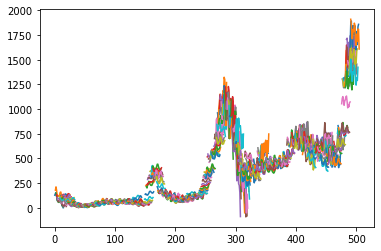

In [246]:
for i, prd in enumerate(total_daily_prds[:]):
    plt.plot(range(i, i+LABEL_WIDTH), prd)
plt.show()

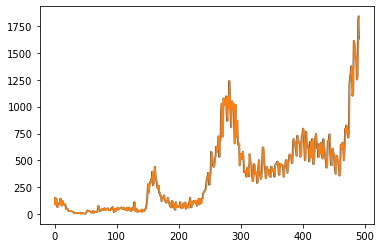

In [266]:
total_daily_targ = scaler.inverse_transform(tf.squeeze(total_targ)).cumsum(axis=1) + daily_data
plt.plot(total_daily_targ[:, 0])
plt.plot(daily_data)
# plt.plot(total_daily_prds[:, 0])

plt.show()

In [274]:
daily_data[:2], total_daily_targ[:3, 0]

(array([[ 93],
        [152]]),
 array([152.,  87., 147.]))

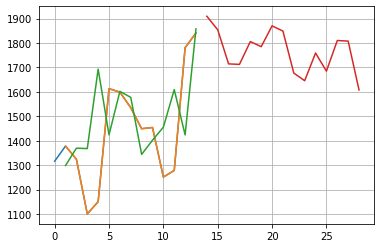

In [310]:
past_step = 14
plt.plot(daily_data[-past_step:])
plt.plot(range(1, past_step), total_daily_targ[-past_step:-1, 0])
plt.plot(range(1, past_step), total_daily_prds[-past_step:-1, 14])
plt.plot(range(past_step, past_step+LABEL_WIDTH), total_daily_prds[-1, :])
plt.grid()
plt.show()

In [296]:
for step in range(15):
    print(step, (
        RMSE(total_daily_targ[:, 0], total_daily_prds[:, step]),
        MAE(total_daily_targ[:, 0], total_daily_prds[:, step]),
        MAPE(total_daily_targ[:, 0], total_daily_prds[:, step]),
    ))

0 (78.2204982912899, 49.2811154478222, 0.27326791965539715)
1 (78.51784351149037, 50.51077663220041, 0.2737028942233309)
2 (92.16733754439811, 58.47472891356887, 0.2925480581953502)
3 (98.75433904763909, 61.18083628067156, 0.258040709895844)
4 (93.33632398757399, 60.70466922596097, 0.2507700491254026)
5 (90.98009159062241, 57.4987758916568, 0.2376412667110363)
6 (92.07870047376686, 57.73468103132597, 0.24455668070251843)
7 (90.6213464213305, 57.175523720621094, 0.29494994400706226)
8 (100.7474713869565, 61.73547818045306, 0.4072120040140803)
9 (97.79516436056923, 63.13225329770305, 0.49678341561195644)
10 (100.36653028838342, 66.36283709048256, 0.5300472929690838)
11 (106.04717003956588, 67.80030119273721, 0.5054946801350529)
12 (107.90986953817406, 69.20723202897281, 0.47623623861312786)
13 (113.10342035145014, 70.41448927991759, 0.4600722102316037)
14 (131.05282102434555, 76.1796675891411, 0.4927662648251159)


In [286]:
evaluation(total_daily_targ, total_daily_prds)

array([106.35,  89.48,   0.48])

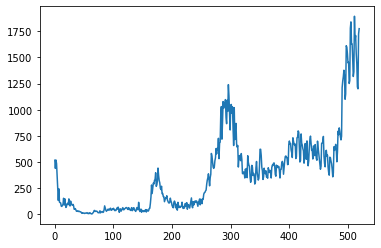

In [58]:
plt.plot(np.diff(covid_data[["decideCnt"]], n=1, axis=0))

In [221]:
covid_data

,accDefRate,accExamCnt,accExamCompCnt,careCnt,clearCnt,createDt,deathCnt,decideCnt,examCnt,resutlNegCnt,seq,stateDt,stateTime,updateDt
0,5.329140,125851,90296,4159,34,2020-03-03 10:46:53.53,28,4812,35555,85484,62,20200303,00:00,2020-03-03 10:46:53.53
1,4.919986,136707,108293,4750,41,2020-03-04 10:21:44.44,32,5328,28414,102965,63,20200304,00:00,2020-03-04 10:21:44.44
2,4.622748,146541,124731,5255,88,2020-03-05 10:15:12.12,35,5766,21810,118965,64,20200305,00:00,2020-03-05 10:15:12.12
3,4.397235,164740,142908,5643,108,2020-03-06 12:55:44.44,42,6284,21832,136624,65,20200306,00:00,2020-03-06 12:55:44.44
4,4.267543,178189,158569,6134,118,2020-03-07 11:00:45.45,44,6767,19620,151802,66,20200307,00:00,2020-03-07 11:00:45.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,1.765422,11772604,11385434,22297,176605,2021-08-02 09:37:51.966,2099,201001,387170,11184433,591,20210802,00:00,2021-08-03 11:08:09.679
518,1.770321,11820016,11421716,22188,177909,2021-08-03 09:38:51.531,2104,202201,398300,11219515,592,20210803,00:00,2021-08-04 09:58:25.377
519,1.778473,11864245,11466356,22697,179123,2021-08-04 09:49:14.864,2106,203926,397889,11262430,593,20210804,00:00,NaN
520,1.789811,11908436,11492947,22874,180719,2021-08-05 09:50:52.915,2109,205702,415489,11287245,594,20210805,00:00,NaN


In [222]:
207406-205702

1704

In [223]:
covid_data["decideCnt"]

0        4812
1        5328
2        5766
3        6284
4        6767
        ...  
517    201001
518    202201
519    203926
520    205702
521    207406
Name: decideCnt, Length: 522, dtype: int64

In [73]:
daily_data.shape, total_daily_prds.shape

((506, 1), (506, 15))

In [233]:
total_inverse_prds.shape

(77, 15)

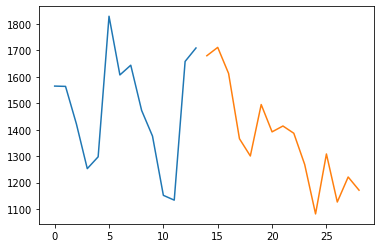

In [240]:
tmp = scaler.inverse_transform(tf.squeeze(total_inp))
plt.plot(tmp[-1, :].cumsum() + daily_data[-1])
plt.plot(range(14, 29), total_inverse_prds[-1, :].cumsum() + daily_data[-1])
plt.show()

In [219]:
first_diff[-1]

array([1776])

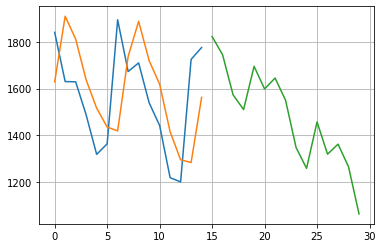

In [241]:
plt.plot(first_diff[-15:])
plt.plot(total_daily_prds[-16:-1, 0])
plt.plot(range(15, 30), total_daily_prds[-1, :])
plt.grid()
plt.show()

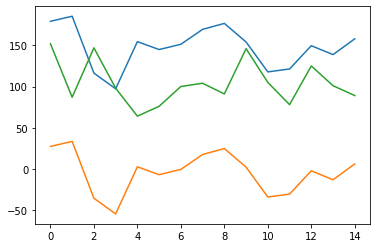

In [102]:
plt.plot(total_inverse_prds[1, :]+daily_data[1])
plt.plot(total_inverse_prds[1, :])
plt.plot(daily_data[1:15+1])

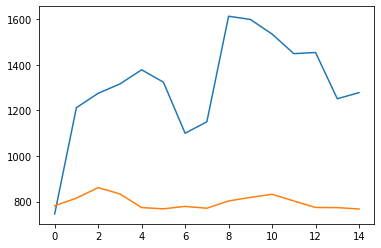

In [157]:
plt.plot(daily_data[475:475+15])
plt.plot(total_daily_prds[475, :])
plt.show()

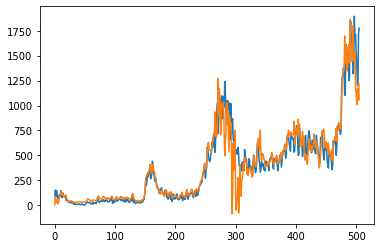

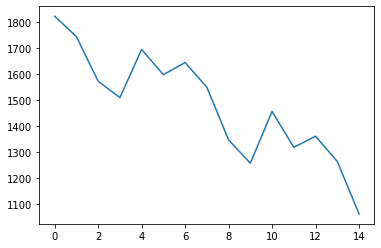

In [156]:
plt.plot(daily_data)
plt.plot(total_daily_prds[:, 14])
plt.show()
plt.plot(total_daily_prds[-1, :])
plt.show()

In [27]:
test_inp, test_targ = list(ds.test.batch(ds.test_size))[0]

test_enc_out, test_enc_state = seq2seq_model.layers[2](test_inp[0])
test_prds = tf.cast(test_inp[1][:, :1], dtype=tf.float32)
for step in range(LABEL_WIDTH):
    prd = seq2seq_model.layers[3](test_prds, test_enc_state, test_enc_out)
    test_prds = tf.concat([test_prds, prd[:, -1:, tf.newaxis]], axis=1)
test_prds = tf.squeeze(test_prds[:, 1:], axis=-1)
test_prds.shape

TensorShape([77, 15])

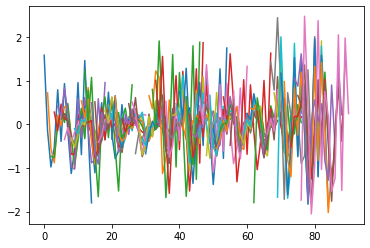

In [28]:
for i, prd in enumerate(test_prds):
    plt.plot(range(i, i+LABEL_WIDTH), prd)
plt.show()
plt.close()

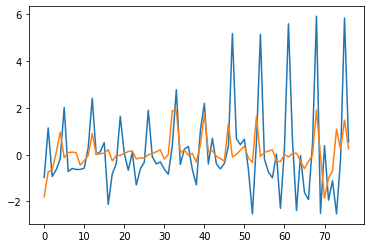

In [30]:
plt.plot(np.diff(test_targ[:, 14], n=0, axis=0))
plt.plot(np.diff(test_prds[:, 14], n=0, axis=0))
plt.show()
plt.close()

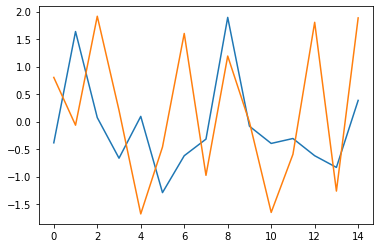

In [31]:
plt.plot(np.diff(test_targ[-45, :], n=0, axis=0))
plt.plot(np.diff(test_prds[-45, :], n=0, axis=0))
plt.show()
plt.close()

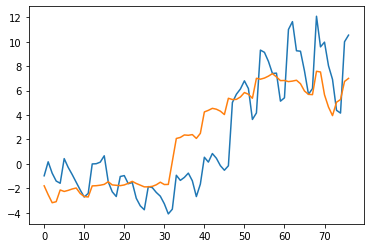

In [32]:
plt.plot(np.cumsum(test_targ[:, 14]))
plt.plot(np.cumsum(test_prds[:, 14]))
plt.show()
plt.close()

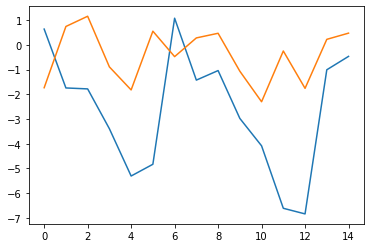

In [35]:
plt.plot(np.cumsum(test_targ[-1, :]))
plt.plot(np.cumsum(test_prds[-1, :]))
plt.show()
plt.close()

In [140]:
evaluation(test_targ, test_prds)

array([1.5 , 1.08, 2.03])

In [149]:
INPUT_WIDTH, LABEL_WIDTH, LAYER_SIZE, DROPOUT

(14, 15, 512, 0.2)

In [150]:
seq2seq_model.save_weights(f"./saved/seq2seq_iw{INPUT_WIDTH}_lw{LABEL_WIDTH}_ls{LAYER_SIZE}_do{DROPOUT}_diff{2}.h5")

256


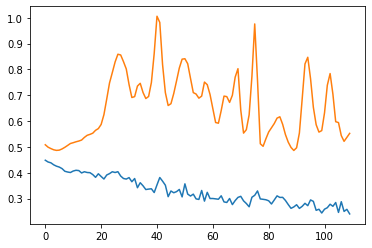

256 [1.55 1.15 2.41]
512


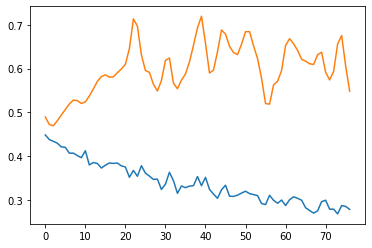

512 [1.5  1.11 2.09]
1024


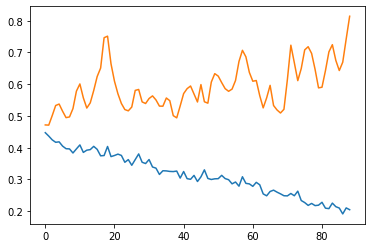

1024 [1.79 1.36 3.54]
2048


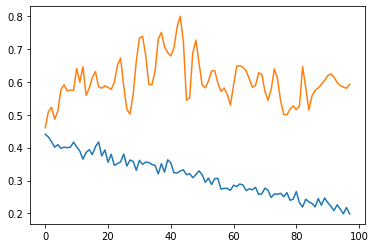

2048 [1.63 1.21 2.19]


In [130]:
# 하이퍼 파라미터 테스트 (layer size)

for layer_size in [256, 512, 1024, 2048]:
    print(layer_size)
    target_data = covid_data[["decideCnt"]].values
    target_data = np.diff(target_data, n=2, axis=0)
    scaler = StandardScaler()
    scaler.fit(target_data)
    scaled_data = scaler.transform(target_data)
    ds = dataset.DataSlicer(scaled_data, scaled_data, INPUT_WIDTH, LABEL_WIDTH, teacher_force=True)

    seq2seq_model = seq2seq.get_model(layer_size, INPUT_WIDTH, 1, LABEL_WIDTH, 1, DROPOUT, ATTENTION)
    history = seq2seq_model.fit(ds.train.batch(BATCH_SIZE), validation_data=ds.val.batch(BATCH_SIZE),
                                epochs=200, verbose=0, callbacks=[
                                    callbacks.EarlyStopping(min_epoch=50, patience=20)
                                ])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    plt.close()

    test_inp, test_targ = list(ds.test.batch(ds.test_size))[0]

    test_enc_out, test_enc_state = seq2seq_model.layers[2](test_inp[0])
    test_prds = tf.cast(test_inp[1][:, :1], dtype=tf.float32)
    for step in range(LABEL_WIDTH):
        prd = seq2seq_model.layers[3](test_prds, test_enc_state, test_enc_out)
        test_prds = tf.concat([test_prds, prd[:, -1:, tf.newaxis]], axis=1)
    test_prds = tf.squeeze(test_prds[:, 1:], axis=-1)
    print(layer_size, evaluation(test_targ, test_prds))

7


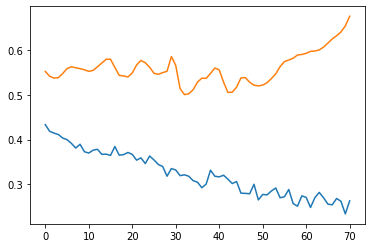

7 [1.48 1.11 2.05]
14


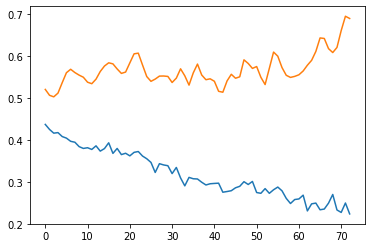

14 [1.49 1.09 2.04]
21


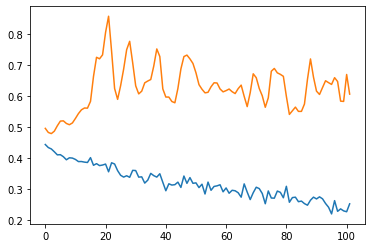

21 [1.71 1.29 3.25]
28


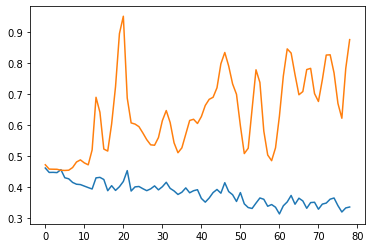

28 [2.1  1.62 4.3 ]
35


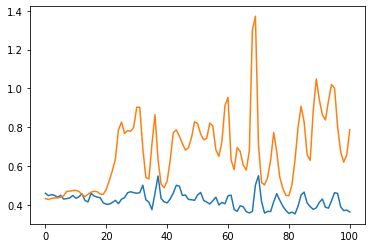

35 [2.26 1.71 4.71]


In [132]:
# 하이퍼 파라미터 테스트 (layer size)

for input_width in [7, 14, 21, 28, 35]:
    print(input_width)
    target_data = covid_data[["decideCnt"]].values
    target_data = np.diff(target_data, n=2, axis=0)
    scaler = StandardScaler()
    scaler.fit(target_data)
    scaled_data = scaler.transform(target_data)
    ds = dataset.DataSlicer(scaled_data, scaled_data, input_width, LABEL_WIDTH, teacher_force=True)

    seq2seq_model = seq2seq.get_model(512, input_width, 1, LABEL_WIDTH, 1, DROPOUT, ATTENTION)
    history = seq2seq_model.fit(ds.train.batch(BATCH_SIZE), validation_data=ds.val.batch(BATCH_SIZE),
                                epochs=200, verbose=0, callbacks=[
                                    callbacks.EarlyStopping(min_epoch=50, patience=20)
                                ])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    plt.close()

    test_inp, test_targ = list(ds.test.batch(ds.test_size))[0]

    test_enc_out, test_enc_state = seq2seq_model.layers[2](test_inp[0])
    test_prds = tf.cast(test_inp[1][:, :1], dtype=tf.float32)
    for step in range(LABEL_WIDTH):
        prd = seq2seq_model.layers[3](test_prds, test_enc_state, test_enc_out)
        test_prds = tf.concat([test_prds, prd[:, -1:, tf.newaxis]], axis=1)
    test_prds = tf.squeeze(test_prds[:, 1:], axis=-1)
    print(input_width, evaluation(test_targ, test_prds))